The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1,502 out of 2,224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class. Here, I'll use machine learning tools to complete the analysis of which of people were likely to survive the sinking.

Let's begin by importing the appropriate Python libraries and reading in the data set.

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.svm import SVC
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

df = pd.read_csv('/Users/degrave/DataScience/Site/titanic/train.csv')

Now let's take a look at the data column headers to see what we're working with.

In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.head()

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450 

The dataframe contains information regarding passenger name, age, sex, and class, among several other things. A description of each of the data columns is shown in the table below.

In [ ]:
VARIABLE DESCRIPTIONS:
survival        Survival (0 = No; 1 = Yes)
pclass          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Let's summarize the data in another way.

In [ ]:
df.info()

RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

We see that the data contian 891 rows and 12 columns. We can also see that the 'Age', 'Cabin', and 'Embarked' columns contain missing values. We will go through these in turn to try and fill them in (or remove them) as best we can. Column 'Survived' contains no missing values; after running our classifier, we'll use k-fold cross-validation to get an estimate of classificationa accuracy. Before we begin, let's first take a quick look at the overall survival rates for men and women.

(0, 1)

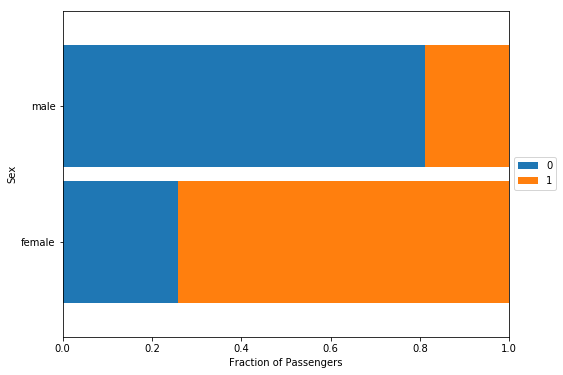

In [58]:
xtab = pd.pivot_table(df, index='Sex', columns='Survived', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Passengers')
mp.ylabel('Sex')
mp.xlim(0,1)

Females were overwhelmingly more likley to survive the sinking than were males. Approximately 75% of all females survived, while only about 20% of males did. One could probably make a reasonable prediction of survival rates simply based on gender alone! However, there is still alot of additional useful information contained in the data that we can use to improve our predictions.

Next, let's take a look at the passenger class information. I remember reading at some point that survival rates were very much dependent upon which class you were in. First class passengers were likely given preferential treatment and were situated closer to the upper deck, possibly making it easier for them to quickly escape the ship. Unfortunatley, second and third class passengers were not so lucky.

Text(0,0.5,'Number of Passengers')

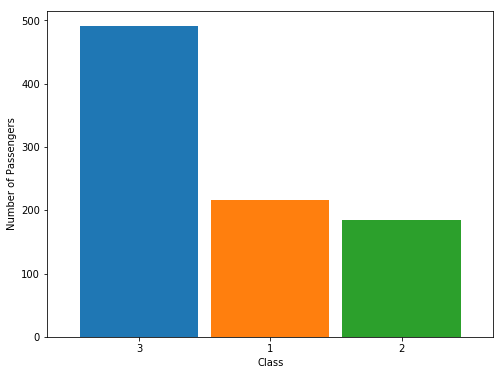

In [40]:
df['Pclass'].value_counts().plot.bar(width=0.9, rot=0, figsize=(8,6))

mp.xlabel('Class')
mp.ylabel('Number of Passengers')

The majority of individuals aboard Titanic were third class passengers. Let's see if passenger class played a role in survival.

(0, 1)

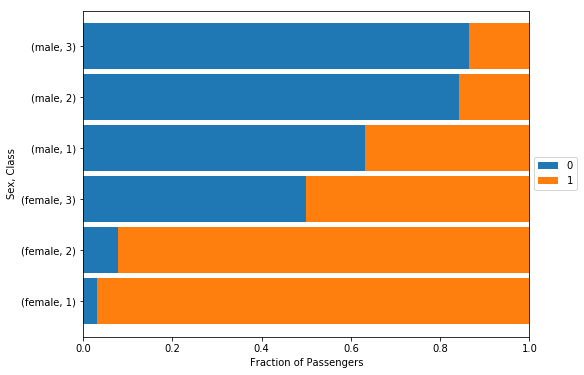

In [53]:
xtab = pd.pivot_table(df, index=['Sex','Pclass'], columns='Survived', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Passengers')
mp.ylabel('Sex, Class')
mp.xlim(0,1)

There does indeed appear to be a correlation between passenger class and survival rate for both males and females. In all, roughly 60% of first class passengers survived, with survival rates decreasing significantly for each subsequent class.

Next, let's take a look at the distribution of passengers among the various ports of departure.

Text(0,0.5,'Number of Passengers')

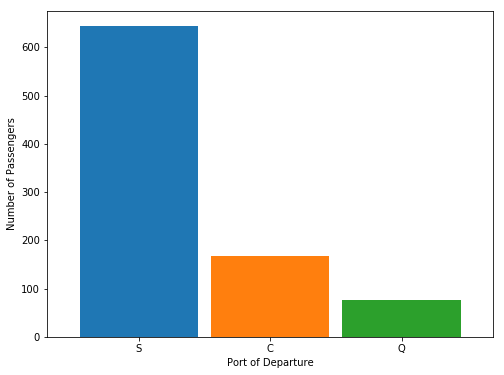

In [54]:
df['Embarked'].value_counts().plot.bar(width=0.9, rot=0, figsize=(8,6))

mp.xlabel('Port of Departure')
mp.ylabel('Number of Passengers')

The overwhelming majority of passengers departed from the Southampton port. Let's see if there is a relationship between port of departure and survival rate. Naively, I would hazard a guess that the relationship, if any exists, is very small. After all, why would the fate of, for example, a second class male passenger embarking from Queenstown (listed as 'Q' in the Embarked column) differ from one embarking from Southampton (listed as 'S' in the Embarked column)?

(0, 1)

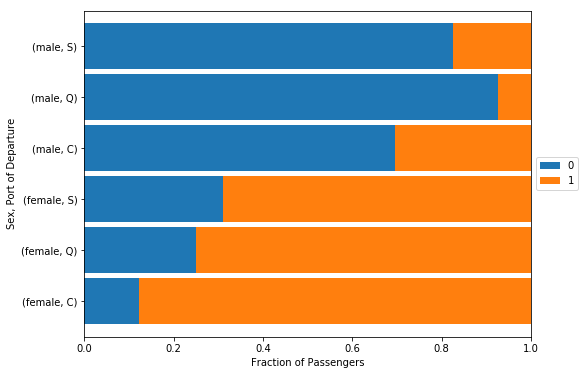

In [59]:
xtab = pd.pivot_table(df, index=['Sex','Embarked'], columns='Survived', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Passengers')
mp.ylabel('Sex, Port of Departure')
mp.xlim(0, 1)

I'm a bit surprised that the effect is so large. Maybe there's more to this than meets the eye. It's likely that this effect is not due simply to geographic location in itself. Perhaps certain ports are located in places where passenger wealth levels were very different? For example, significantly more passengers embarking from Cherbourg survived than did those embarking from port Southampton. Perhaps more wealthy individuals (i.e. first class passengers) boarded at Cherbourg, while a larger fraction of poorer individuals (i.e., second and third class passengers) boarded at Southampton and Queenstown. In other words, the effect we're seeing may simply be a reflection of passenger class, among other things. Let's take a look!

(0, 1)

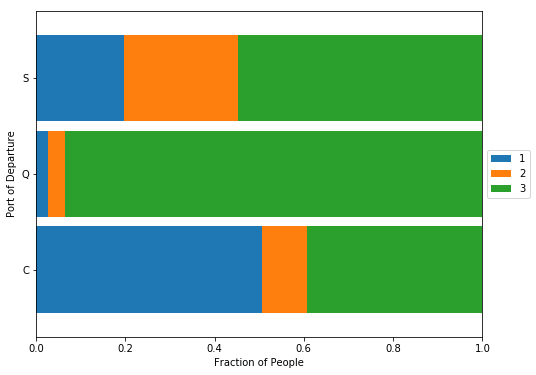

In [62]:
xtab = pd.pivot_table(df, index=['Embarked'], columns='Pclass', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of People')
mp.ylabel('Port of Departure')
mp.xlim(0,1)

Our hypothesis was correct in that port of departure and passenger class seem to be related. Individuals embarking from Cherbourg port were largely first class passengers, while the majority of those embarking from Queenstown and Southampton were second and third class passengers. This may explain the previous figure suggesting Cherbourg passengers had better survival rates. However, passengers embarking from Queenstown had overall survival rates that were higher than Southampton even though more third class passengers boarded there, which is a bit surprising. Maybe there is some additional factor at play?

As we saw earlier, there are only a couple of missing values in the 'Embarked' column. Since the vast majority of passengers departed from Southampton, we'll fill in the missing values with this location.

We also have information available regarding passenger ticket fares. Let's take a look at the distribution of these values.

Text(0.5,0.98,'')

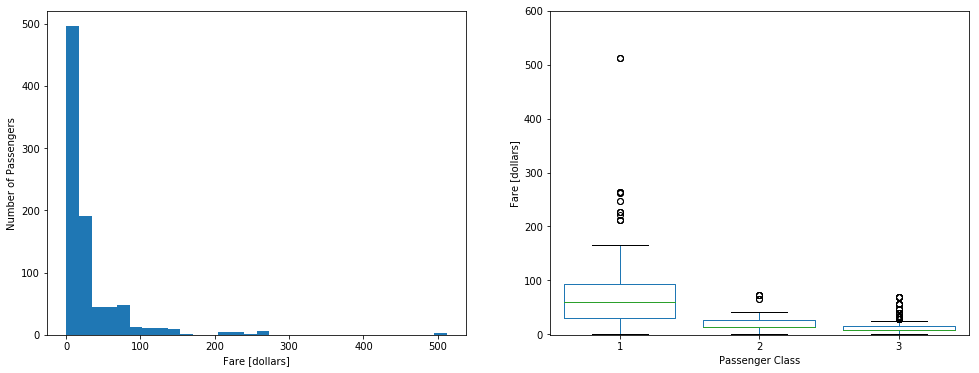

In [117]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df['Fare'].dropna().hist(bins=30, grid=False, ax=axes[0])
ax.set_xlabel('Fare [dollars]')
ax.set_ylabel('Number of Passengers')

ax = df.boxplot(by='Pclass', column='Fare', grid=False, widths=(0.8, 0.8, 0.8), ax=axes[1])
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Fare [dollars]')
ax.set_ylim([-1,600])
ax.set_title('')
fig.suptitle('')

The lefthand figure above shows a histogram of fare values for all passengers. It looks like the vast majority of people paid fares that were less than about $25, but there is considerable spread in the data. It seems reasonable to guess that first class passengers paid fares that were higher on average than those passengers lodging in second or third class cabins. The righthand figure above shows boxplots of fare values for passengers in each class. Ticket fares for second and third class passengers were in fact quite a bit lower than for individuals in the first class. Since the fare column only has one missing value, let's fill it in with the median fare value of all third class pasengers.

In [108]:
df['Fare'] = df['Fare'].fillna(df.loc[df['Pclass'] == 3, 'Fare'].median())

Lastly, of the 891 passengers in our data, there are 177 missing ages. Let's take a look at the distribution of values in the 'Age' column.

Text(0.5,0.98,'')

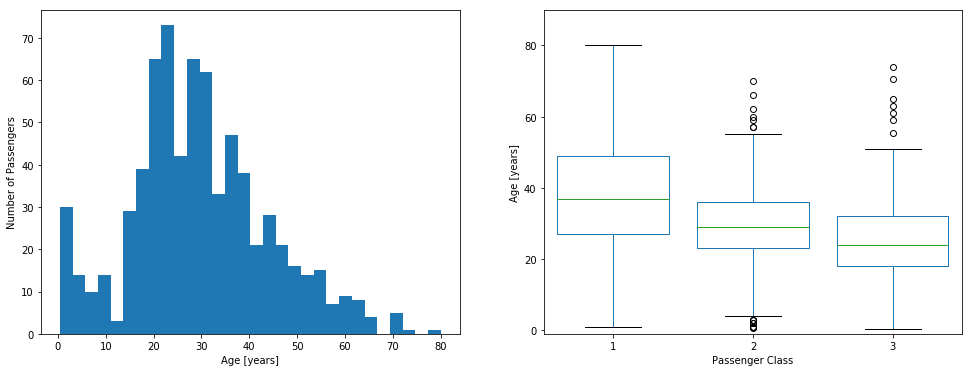

In [118]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df['Age'].dropna().hist(bins=30, grid=False, ax=axes[0])
ax.set_xlabel('Age [years]')
ax.set_ylabel('Number of Passengers')

ax = df.boxplot(by='Pclass', column='Age', grid=False, widths=(0.8, 0.8, 0.8), ax=axes[1])
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Age [years]')
ax.set_ylim([-1,90])
ax.set_title('')
fig.suptitle('')

The lefthand figure above shows a histogram of all available age values in our data. The majority of individuals were between about 20 and 40 years of age, though the tail of the distribution extends to much higher values. The righthand figure above shows the distribution of ages between the three passenger classes. There is a clear difference in median age between the classes, with first class passengers being older on average than second or third class passengers. This makes sense in the sense that first class passengers were wealthier on average, and a great deal of wealth may take several years to acquire.

Rather than simply filling in missing age values with the population median or mean, we can do something a little bit better. Let's fill in the missing values by class.

In [119]:
def fillage(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass==1:
            return df.loc[df['Pclass'] == 1, 'Age'].median()
        elif Pclass==2:
            return df.loc[df['Pclass'] == 2, 'Age'].median()
        elif Pclass==3:
            return df.loc[df['Pclass'] == 3, 'Age'].median()
    else:
        return Age

df['Age'] = df[['Age','Pclass']].apply(fillage, axis=1)

df['AgeClass'] = df['Age']
df.loc[(df['Age'] > 0)  & (df['Age'] <= 10), 'AgeClass'] = '0 - 10 years'
df.loc[(df['Age'] > 10) & (df['Age'] <= 20), 'AgeClass'] = '10 - 20 years'
df.loc[(df['Age'] > 20) & (df['Age'] <= 40), 'AgeClass'] = '20 - 40 years'
df.loc[(df['Age'] > 40) & (df['Age'] <= 60), 'AgeClass'] = '40 - 60 years'
df.loc[(df['Age'] > 60), 'AgeClass']                     = '> 60 years'

(0, 1)

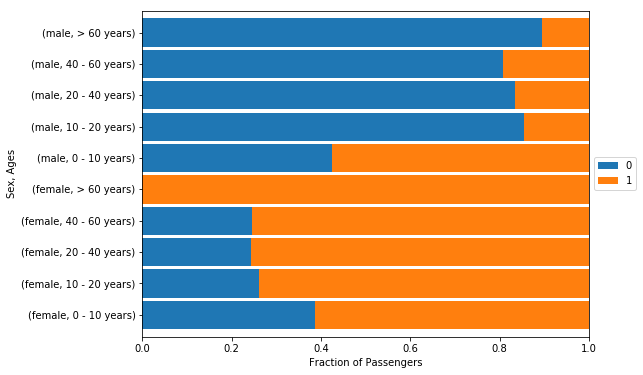

In [123]:
xtab = pd.pivot_table(df, index=['Sex','AgeClass'], columns='Survived', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Passengers')
mp.ylabel('Sex, Ages')
mp.xlim(0,1)

There is some relationship betwee age and survival rate for both men and women. Males in the 0-10 year age range (i.e., children) were much more likely to survive than any other age group. Males above about 10 years of age were almost equally unlucky in terms of survival. Interestingly, female survival rate increased with age. Females in the 0-10 year age range were less likely to survive than older females, and all females above 60 years of age survived the sinking.

It's possible that we can improve the performance of our classifier if we do a little bit of feature engineering here. The 'Name' column contains titles such as Mr., Master, Miss, etc. Perhaps we can gather some useful survival information by separating out these titles and making them a separate feature.

In [126]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

We can also create a new feature which takes into account total family size. This is the sum of the Parch (number of parents or children an individual has with them on the ship) and SibSp (the number of siblings or spouses an individual has with them) columns. It seems possible that those with larger families were less likely to survive, as it was probably difficult to wrangle everyone together in the chaos of the sinking.

In [127]:
df['FamSize'] = df['Parch'] + df['SibSp']

Now that we have explored the data a little bit, we need to first encode our categorical features before we start making predictions. Encoding simply means we convert the strings in these columns to numerical values. Below, we convert the strings to dummy variables using the Pandas get_dummies command.

In [128]:
sex      = pd.get_dummies(df['Sex'], drop_first=True)
embarked = pd.get_dummies(df['Embarked'], drop_first=True)
parch    = pd.get_dummies(df['Parch'], drop_first=True)
title    = pd.get_dummies(df['Title'], drop_first=True)
ageclass = pd.get_dummies(df['AgeClass'], drop_first=True)
famsize  = pd.get_dummies(df['FamSize'], drop_first=True)

df = pd.concat([df,sex,embarked,parch,title,ageclass,famsize], axis=1)
df.drop(['Sex','Embarked','Parch','Title','AgeClass','FamSize','Name'], axis=1, inplace=True)

One will note that the 'Cabin' column still contains 687 missing values that we have not bothered to fill in. Since there are so many, trying to fill them in accurately may simply result in noise being added to the problem, thereby hindering our classification performance rather than helping it. To this end, I'll elect to drop the 'Cabin' column altogether. Also, the 'Ticket' column has a rather complicated format, and so we will drop this column as well rather than struggling to gain useful information from it.

In [129]:
df.drop(['Cabin','Ticket'], axis=1, inplace=True);

We can now define the response (i.e., the target) and the feature arrays. It is also good practice to scale the feature data take on a similar range of values. This can be done easily using the StandardScaler function.

In [130]:
sc = StandardScaler()

y = df['Survived']
X = df.drop(['Survived','PassengerId'], axis=1)

X = sc.fit_transform(X)

We'll try two different approaches here - logistic regression and random forests.

In [139]:
models = {'Logistic Regression': LogisticRegression(C=1), 'Random Forest': RandomForestClassifier(n_estimators=250)}

for i in models.keys():
    scores = []
    scores = cross_val_score(models[i], X, y, cv=10)
    mn = np.round(np.mean(scores), 2)
    st = np.round(np.std(scores), 2)
    print(i, (mn, st))

Logistic Regression (0.82, 0.03)
Random Forest (0.81, 0.04)


It looks like both models perform very similarly in a head-to-head 10-fold cross-validation test. We'll go ahead and use a random forest model to perform the necessary final classification. Of the various tunable random forest parameters, two of the most important are the number of trees in the forest and the maximum depth of the trees. We can try and find optimal values for these parameters by using Scikit-Learn's GridSearchCV function. We will try three n_estimator (number of trees in the forest) values, and three max_depth (depth of the trees) values.

In [142]:
params = {'n_estimators': [200,250,300,350], 'max_depth': [3,5,7]}

grid = GridSearchCV(RandomForestClassifier(criterion='gini'), params, cv=5, scoring='accuracy')

grid.fit(X, y)
grid.best_params_

{'max_depth': 5, 'n_estimators': 250}

The grid search results in values of 250 and 5 for parameters n_estimators and max_depth respectively.

In [151]:
model = RandomForestClassifier(criterion='gini', n_estimators=250, max_depth=5)

scores = cross_val_score(model, X, y, cv=10)
print(np.round(np.mean(scores), 2))

0.83


Cross-validation suggests that we correctly predict survival about 83% of the time! Not too bad. Scikit-Learn's RandomForestClassifier allows us to examine the most important features used in predicting survival rates. Let's see what the top ten features are.

In [166]:
n = pd.DataFrame()

n['x'] = feat_labels[indices[:ncomp]]
n['y'] = importances[indices[:ncomp]]

Text(0.5,0,'')

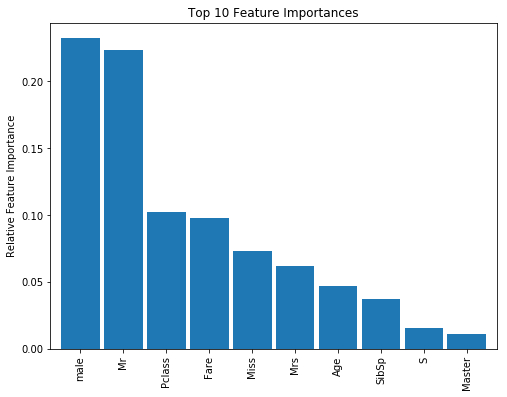

In [171]:
feat_labels = df.drop(['PassengerId','Survived'], axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

ncomp = 10

n.plot.bar(x='x', width=0.9, legend=False, figsize=(8,6))
mp.title('Top 10 Feature Importances')
mp.ylabel('Relative Feature Importance')
mp.xticks(rotation=90)
mp.xlabel('')

Looking at the plot of feature importance, it looks like sex, fare, and passenger class, along with various titles (for example, 'Mr', 'Miss', etc.) were far and away the most significant indicators of whether or not an individual survived the sinking. Perhaps a bit surprisingly, port of departure played a relatively small role overall.

Well, that's all for now. Thanks for following along!